<a href="https://colab.research.google.com/github/esa-prakasa/autov/blob/master/BinaryLaneDetectionFz3x3resize20pct_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load dan mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/dataset/rdtest/"
#!ls -l "/content/drive/My Drive/Colab Notebooks/dataset"

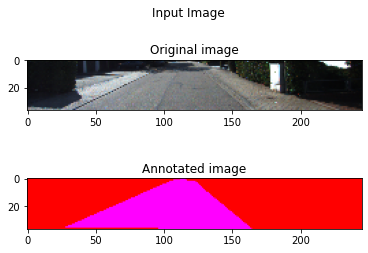

In [0]:
import cv2
import os
import matplotlib.pyplot as plt

folderCode = "203/"
folderCode = "204/"
folderCode = "205/"
folderCode = "206/"
folderCode = "207/"
folderCode = "210/"
folderCode = "249/"
folderCode = "270/"
folderCode = "273/"
folderCode = "281/"



imgPath = "/content/drive/My Drive/Colab Notebooks/dataset/rdtest/"+folderCode


fileList = []

for r, d, f in os.walk(imgPath):
		for file in f:
			typeCode = file[:4]
			if typeCode == "aOri":
				oriImgF = file
			if typeCode == "bLab":
				labImgF = file

oriImg = cv2.imread(os.path.join(r,oriImgF))
labImg = cv2.imread(os.path.join(r,labImgF))


M = labImg.shape[0]
N = labImg.shape[1]

b,g,r =  cv2.split(oriImg)
oriImgRGB = cv2.merge([r,g,b])

b,g,r =  cv2.split(labImg)
labImgRGB = cv2.merge([r,g,b])


fig, axs = plt.subplots(2,1)
fig.suptitle("Input Image")
axs[0].set_title('Original image')
axs[0].imshow(oriImgRGB)

axs[1].set_title('Annotated image')
axs[1].imshow(labImgRGB)
plt.show()



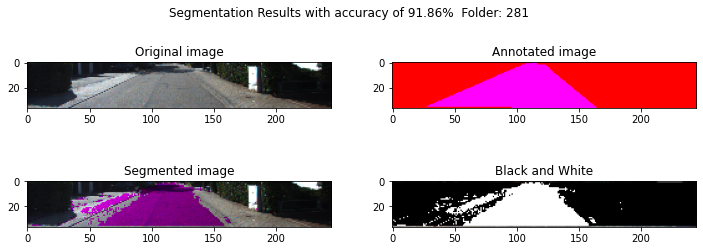

In [0]:
import numpy as np

def getDataPoints(boxMat):
	M = boxMat.shape[0]
	N = boxMat.shape[1]

	bl = []
	gr = []
	rd = []

	for i in range(M):
		if (i%2)==0:
			for j in range (N):
				bl.append(boxMat[i,j,0])
				gr.append(boxMat[i,j,1])
				rd.append(boxMat[i,j,2])
		if (i%2)==1:
			for j in range ((N-1),-1,-1):
				bl.append(boxMat[i,j,0])
				gr.append(boxMat[i,j,1])
				rd.append(boxMat[i,j,2])
	return rd,gr,bl


def reshapeRGB(rd,gr,bl):
	N = len(rd)
	N2 = 2*N
	#rgb = np.zeros((N*3, 1, 1), dtype = "uint8")
	rgb = [0]*(N*3)
	for i in range(N):
		rgb[i]    = rd[i]
		rgb[i+N]  = gr[i]
		rgb[i+N2] = bl[i]

	rgbStr =""
	for i in range(N*3):
		rgbStr = rgbStr+str(rgb[i])+","
	#rgbStr = rgbStr[:-1]

	return rgb,rgbStr






M = labImg.shape[0]
N = labImg.shape[1]

#print(M)
#print(N)

X = np.zeros((M*N, 29))
Y = np.zeros((M*N, 1))

roadClass = 0


filterSize = 3
fd = filterSize//2


idx = 0
for i in range(fd,(M-fd),1):
  for j in range (fd,(N-fd),1):
    #print(idx)
    X[idx, 0] = i
    X[idx, 1] = j
    boxMat =np.zeros((filterSize, filterSize, 3), dtype = "uint8")
		
    for k in range(-fd,(fd+1),1):
      for l in range(-fd,(fd+1),1):
        boxMat[(k+fd),(l+fd),0] = oriImg[(i+k),(j+l),0]
        boxMat[(k+fd),(l+fd),1] = oriImg[(i+k),(j+l),1]
        boxMat[(k+fd),(l+fd),2] = oriImg[(i+k),(j+l),2]

    [rd,gr,bl] = getDataPoints(boxMat)
    [nRGB,rgbStr] = reshapeRGB(rd,gr,bl)
    #print(rgbStr)
    
    for k in range(9):
      X[idx,k+2] =  rd[k]
      X[idx,k+11] = gr[k]
      X[idx,k+20] = bl[k]

    bRef = labImg[i,j,0]

    if (bRef==0):  ##>>> Non Road
      roadClass = 0
    if (bRef==255):   ##>>> ROAD
      roadClass = 1

    Y[idx, 0] = roadClass
    idx = int(idx + 1)

#print(X[0:2,:])
#print(Y[0:2,:])

X0 = X.copy()
#print(idx)

#print(X)
#print(Y)

### ========================================================
### ========================================================
### ========================================================

#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = X
Y_test = Y
from keras.models import model_from_json
path = "/content/drive/My Drive/Colab Notebooks/dataset/"



# load json and create model
json_file = open((path+'lane200_20pct.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path+"lane200_20pct_wg.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
result = loaded_model.predict(X_test)
finClass = np.round(result)
c3 = [result, finClass]


Nx = len(c3[0])

segImg = oriImg.copy()
bwImg = oriImg.copy()

for i in range(Nx):
  
  ii = int(X0[i,0])
  jj = int(X0[i,1])
  clsIdx = int(c3[1][i])
  if (clsIdx == 1):
    segImg[ii,jj,1] = 0
    bwImg[ii,jj,0] = 255
    bwImg[ii,jj,1] = 255
    bwImg[ii,jj,2] = 255
  if (clsIdx == 0):
    bwImg[ii,jj,0] = 0
    bwImg[ii,jj,1] = 0
    bwImg[ii,jj,2] = 0

#  if (clsIdx == 0):
#    pass
 # print("%d %d %d "%(ii, jj, clsIdx))


b,g,r =  cv2.split(segImg)
segImgRGB = cv2.merge([r,g,b])

fig, axs = plt.subplots(2,2,figsize=(12,4))
#fig= plt.figure(figsize=(600,300))

fig.suptitle("Segmentation Results with accuracy of %.2f%%  Folder: %s "%((score[1]*100),folderCode[:-1]))
axs[0,0].set_title('Original image')
axs[0,0].imshow(oriImgRGB)

axs[0,1].set_title('Annotated image')
axs[0,1].imshow(labImgRGB)


axs[1,0].set_title('Segmented image')
axs[1,0].imshow(segImgRGB)

axs[1,1].set_title('Black and White')
axs[1,1].imshow(bwImg)

plt.show()

del segImg